In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

from sklearn.preprocessing import scale
import sklearn.cluster as cluster

In [2]:
crashes_json_file = "data/crashes.json"
traffic_json_file = "data/traffic.json"
hospitals_csv_file = "data/hospitals.csv"
postcodes_csv_file = "data/postcodes.csv"

# Dataset preparation

## Crashes data

Flatten and convert crashes json data into dataframe.

In [3]:
with open(crashes_json_file) as file:
    crashes_data = json.load(file)["features"]
# flatten json and convert to dataframe
crashes_data = pd.json_normalize(crashes_data)
# capitalise column names and delete column name prefixes
crashes_data.columns = crashes_data.columns.str.upper().str.split(".").str[1]
crashes_data.head()

,NaN,OBJECTID,ACCIDENT_N,ACCIDENT_D,ACC_TIME,NO_VEHICLE,ACCIDENT_T,ACC_T_DESC,ABS_CODE,PERSON_ID,...,RD_NAME_2,RD_TYPE_2,DEC_RD_DES,LGA_NAME,REGION_NAM,STAT_DIV_N,AMG_X,AMG_Y,TYPE,COORDINATES
0,Feature,1,T20150013823,2015-07-01T00:00:00Z,03.:0.00,3,1,Collision with vehicle,A,A,...,ATKINSON,STREET,Declared Road,MONASH,METROPOLITAN SOUTH EAST REGION,Melbourne - South East,2508215.796,2400842.975,Point,"[145.0934073467375, -37.89348218481634]"
1,Feature,2,T20150013938,2015-07-02T00:00:00Z,14.:2.00,2,1,Collision with vehicle,A,01,...,BARUNAH PLAINS,ROAD,Declared Road,COLAC OTWAY,SOUTH WESTERN REGION,Country,2393914.484,2380247.44,Point,"[143.7909791626493, -38.07300206363974]"
2,Feature,3,T20150014033,2015-07-03T00:00:00Z,15.:3.00,2,1,Collision with vehicle,A,01,...,OLD WILBY,ROAD,Non Declared Road,MOIRA,NORTH EASTERN REGION,Country,2591342.411,2607576.833,Point,"[146.01343397566194, -36.026082485283816]"
3,Feature,4,T20150014033,2015-07-03T00:00:00Z,15.:3.00,2,1,Collision with vehicle,A,A,...,OLD WILBY,ROAD,Non Declared Road,MOIRA,NORTH EASTERN REGION,Country,2591342.411,2607576.833,Point,"[146.01343397566194, -36.026082485283816]"
4,Feature,5,T20150014077,2015-07-04T00:00:00Z,12.:4.00,2,1,Collision with vehicle,A,A,...,HUME,FREEWAY,Declared Road,MITCHELL,NORTHERN REGION,Country,2508126.719,2488400.553,Point,"[145.09143847997456, -37.10450027848753]"


Remove rows where crash did not occur in Greater Melbourne.

In [4]:
# find all crash site regions in dataset
print(pd.unique(crashes_data["STAT_DIV_N"]))

['Melbourne - South East' 'Country' 'Melbourne - North East'
 'Melbourne - North West' 'Bendigo' 'Melbourne - Inner' 'Melbourne - West'
 'Metro' 'Melbourne - Inner South' 'Melbourne - Outer East'
 'Melbourne - Inner East' 'Ballarat' 'Hume' 'Latrobe - Gippsland']


In [5]:
greater_melbourne = ["Melbourne - South East", "Melbourne - North East",
                     "Melbourne - North West", "Melbourne - Inner",
                     "Melbourne - West", "Metro", "Melbourne - Inner South",
                     "Melbourne - Inner East", "Melbourne - Outer East", "Hume"]
# only include crashes that occurred in Greater Melbourne       
crashes_data = crashes_data[crashes_data["STAT_DIV_N"].isin(greater_melbourne)]
# reset index
crashes_data.reset_index(drop=True, inplace=True)

Convert longitude/latitude (longlat) into easting/northing (UTM) coordinates.

In [6]:
from pyproj import Proj

def longlat_to_utm(longlat):
    projection = Proj(proj='utm', zone=55, ellps='WGS84', south=True)
    # longlat can be an irregular-dimensional list of coordinates 
    # reshape longlat into a regular n by 2 array (n = number of coordinates)
    longlat_flattened = list(pd.core.common.flatten(longlat))
    coordinates = np.reshape(longlat_flattened, (-1, 2))
    utm = [projection(coord[0], coord[1]) for coord in coordinates]
    if len(utm) == 1:
        # a single longlat coordinate was passed as the argument
        utm = utm[0]
    return utm
    
# example conversion
longitude, latitude = longlat = [145.093407346737507, -37.893482184816342]
easting, northing = longlat_to_utm(longlat)
print("Example conversion from longlat to UTM coordinates:")
print("longitude:", longitude, "| latitude:", latitude)
print("easting:  ", easting, "| northing:", northing)

Example conversion from longlat to UTM coordinates:
longitude: 145.0934073467375 | latitude: -37.89348218481634
easting:   332356.7542234912 | northing: 5804289.727742385


In [7]:
# convert each road's list of longlat coordinates into a list of UTM coordinates
crashes_data["COORDINATES"] = crashes_data["COORDINATES"].apply(longlat_to_utm)
# separate COORDINATES column containing list of easting and northing values into two separate columns
utms = pd.DataFrame(
    crashes_data["COORDINATES"].tolist(), 
    columns=['EASTING', 'NORTHING'])
crashes_data = pd.concat([crashes_data, utms], axis=1)

Remove irrelevant columns.

In [8]:
crashes_data = crashes_data[["EASTING", "NORTHING", "ACCIDENT_T", "NO_VEHICLE"]]
crashes_data = crashes_data.rename(columns={"ACCIDENT_T": "ACCIDENT_TYPE"})
crashes_data.head()

,EASTING,NORTHING,ACCIDENT_TYPE,NO_VEHICLE
0,332356.754223,5.804290e+06,1,3
1,323738.934777,5.826285e+06,1,5
2,318355.441610,5.823902e+06,2,2
3,329021.381635,5.825677e+06,2,1
4,328058.324164,5.837223e+06,1,3


## Traffic data

Flatten and convert traffic json data into dataframe.

In [9]:
with open(traffic_json_file) as file:
    traffic_data = json.load(file)['features']
# flatten json and convert to dataframe
traffic_data = pd.json_normalize(traffic_data)
# capitalise column names and delete column name prefixes
traffic_data.columns = traffic_data.columns.str.upper().str.split(".").str[1]
traffic_data.head()

,NaN,OBJECTID_1,OBJECTID,TIS_ID,HMGNS_FLOW_ID,HMGNS_LNK_ID,HMGNS_LNK_DESC,LGA_SHORT_NM,RGN_LONG_NM,ROAD_NBR,...,ALLVEH_PMPEAK_AADT,GROWTH_RATE,CI,AM_PEAK_SPEED,OFF_PEAK_SPEED,PM_PEAK_SPEED,YR,LABEL,TYPE,COORDINATES
0,Feature,1,743,14915,14915,2006,MARYSVILLE-WOODS POINT ROAD btwn LAKE MOUNTAI...,YARRA RANGES,METROPOLITAN SOUTH EAST REGION,4961,...,NaN,0.013,0.005,None,None,None,2020,24* (13% 3*) EAST BOUND,LineString,"[[145.83722698332386, -37.53279795716388], [14..."
1,Feature,2,650,14140,14140,8786,STEELS CREEK ROAD btwn WILLOWBEND DRIVE & ELT...,YARRA RANGES,METROPOLITAN SOUTH EAST REGION,9999,...,NaN,0.019,0.002,None,None,None,2020,373* (6% 22*) NORTH BOUND,LineString,"[[145.37230056828534, -37.60790008878563], [14..."
2,Feature,3,701,12113,12113,6035,LATROBE ROAD btwn TANJIL EAST ROAD & GORDON S...,LATROBE,EASTERN REGION,5911,...,NaN,0.015,0.009,None,None,None,2020,"1,100* (6% 61*) NORTH BOUND",LineString,"[[146.39673725987885, -38.22489975844649], [14..."
3,Feature,4,702,12897,12897,7079,CASTERTON ROAD btwn GLENELG HIGHWAY & COLERAI...,SOUTHERN GRAMPIANS,SOUTH WESTERN REGION,2670,...,NaN,0.020,0.001,None,None,None,2020,801* (21% 165*) WEST BOUND,LineString,"[[141.67690374607355, -37.59193657194991], [14..."
4,Feature,5,703,9893,9893,3475,HUTTON ROAD btwn CHAPEL ROAD & GREENS ROAD,DANDENONG,METROPOLITAN SOUTH EAST REGION,5168,...,1100.0,0.003,0.002,None,None,None,2020,"12,000 (6% 744*) WEST BOUND",LineString,"[[145.17169944947912, -38.011659087218774], [1..."


Convert each road's list of longitude/latitude coordinates into a list of easting/northing (UTM) coordinates. Then, find each road's average easting/northing values (i.e. road midpoint).

In [10]:
# convert each road's list of longlat coordinates into a list of UTM coordinates
traffic_data["COORDINATES"] = traffic_data["COORDINATES"].apply(longlat_to_utm)

# find each road's average easting and northing (UTM) coordinate values
traffic_data["COORDINATES"] = traffic_data["COORDINATES"].apply(
    lambda utms: np.mean(utms, axis=0))
 
# separate COORDINATES column containing list of easting and northing values into two separate columns
utms = pd.DataFrame(
    traffic_data["COORDINATES"].tolist(), 
    columns=['EASTING', 'NORTHING'])
traffic_data = pd.concat([traffic_data, utms], axis=1)
traffic_data.head()

,NaN,OBJECTID_1,OBJECTID,TIS_ID,HMGNS_FLOW_ID,HMGNS_LNK_ID,HMGNS_LNK_DESC,LGA_SHORT_NM,RGN_LONG_NM,ROAD_NBR,...,CI,AM_PEAK_SPEED,OFF_PEAK_SPEED,PM_PEAK_SPEED,YR,LABEL,TYPE,COORDINATES,EASTING,NORTHING
0,Feature,1,743,14915,14915,2006,MARYSVILLE-WOODS POINT ROAD btwn LAKE MOUNTAI...,YARRA RANGES,METROPOLITAN SOUTH EAST REGION,4961,...,0.005,None,None,None,2020,24* (13% 3*) EAST BOUND,LineString,"[399728.04798636603, 5843187.574259409]",399728.047986,5.843188e+06
1,Feature,2,650,14140,14140,8786,STEELS CREEK ROAD btwn WILLOWBEND DRIVE & ELT...,YARRA RANGES,METROPOLITAN SOUTH EAST REGION,9999,...,0.002,None,None,None,2020,373* (6% 22*) NORTH BOUND,LineString,"[356408.24208239757, 5834169.927788794]",356408.242082,5.834170e+06
2,Feature,3,701,12113,12113,6035,LATROBE ROAD btwn TANJIL EAST ROAD & GORDON S...,LATROBE,EASTERN REGION,5911,...,0.009,None,None,None,2020,"1,100* (6% 61*) NORTH BOUND",LineString,"[447773.83591772494, 5772978.382925389]",447773.835918,5.772978e+06
3,Feature,4,702,12897,12897,7079,CASTERTON ROAD btwn GLENELG HIGHWAY & COLERAI...,SOUTHERN GRAMPIANS,SOUTH WESTERN REGION,2670,...,0.001,None,None,None,2020,801* (21% 165*) WEST BOUND,LineString,"[19395.12737591519, 5827289.69113134]",19395.127376,5.827290e+06
4,Feature,5,703,9893,9893,3475,HUTTON ROAD btwn CHAPEL ROAD & GREENS ROAD,DANDENONG,METROPOLITAN SOUTH EAST REGION,5168,...,0.002,None,None,None,2020,"12,000 (6% 744*) WEST BOUND",LineString,"[339012.8296884429, 5791174.284465636]",339012.829688,5.791174e+06


Remove irrelevant columns.

In [11]:
traffic_data = traffic_data[["EASTING", "NORTHING", "TWO_WAY_AADT", "GROWTH_RATE"]]
traffic_data = traffic_data.rename(columns={"TWO_WAY_AADT": "TRAFFIC_VOLUME", "GROWTH_RATE": "TRAFFIC_GROWTH"})
traffic_data.head()

,EASTING,NORTHING,TRAFFIC_VOLUME,TRAFFIC_GROWTH
0,399728.047986,5.843188e+06,40,0.013
1,356408.242082,5.834170e+06,730,0.019
2,447773.835918,5.772978e+06,2300,0.015
3,19395.127376,5.827290e+06,1600,0.020
4,339012.829688,5.791174e+06,24000,0.003


## Postcodes data

Get postcodes data for converting hospital postcodes to longitude/latitude coordinates later.

In [12]:
postcodes_data = pd.read_csv(postcodes_csv_file)
postcodes_data.columns = postcodes_data.columns.str.upper()
postcodes_data.head()

,ID,POSTCODE,LOCALITY,STATE,LONG,LAT,DC,TYPE,STATUS,SA3,...,SA3_NAME_2016,SA4_CODE_2016,SA4_NAME_2016,RA_2011,RA_2016,MMM_2015,MMM_2019,CED,ALTITUDE,CHARGEZONE
0,230,200,ANU,ACT,149.119000,-35.277700,NaN,NaN,NaN,NaN,...,North Canberra,801.0,Australian Capital Territory,1.0,1.0,1.0,1.0,NaN,NaN,N2
1,21820,200,Australian National University,ACT,149.118900,-35.277700,NaN,NaN,Added 19-Jan-2020,NaN,...,North Canberra,801.0,Australian Capital Territory,1.0,1.0,1.0,1.0,NaN,NaN,N2
2,232,800,DARWIN,NT,130.836680,-12.458684,NaN,NaN,Updated 6-Feb-2020,70101.0,...,Darwin City,701.0,Darwin,3.0,3.0,2.0,2.0,NaN,NaN,NT1
3,233,801,DARWIN,NT,130.836680,-12.458684,NaN,NaN,Updated 25-Mar-2020 SA3,70101.0,...,Darwin City,701.0,Darwin,3.0,3.0,2.0,2.0,NaN,NaN,NT1
4,234,804,PARAP,NT,130.873315,-12.428017,NaN,NaN,Updated 25-Mar-2020 SA3,70102.0,...,Darwin City,701.0,Darwin,3.0,3.0,2.0,2.0,NaN,NaN,NT1


Remove rows of postcodes outside of Victoria for a more efficient postcode search (must include postcodes outside of Greater Melbourne as the hospital closest to a crash site in Greater Melbourne could potential be located outside of Greater Melbourne).

In [13]:
# find all unique STATE column values
print(pd.unique(postcodes_data["STATE"]))

['ACT' 'NT' 'SA' 'WA' 'NSW' 'QLD' 'VIC' 'TAS']


In [14]:
postcodes_data = postcodes_data[postcodes_data["STATE"] == "VIC"]
postcodes_data = postcodes_data.drop_duplicates(subset=['POSTCODE'])
postcodes_data.reset_index(drop=True, inplace=True)

Convert longitude/latitude coordinates of postcodes to easting/northing (UTM) coordinates.

In [15]:
# convert each postcode's longlat coordinates into UTM coordinates
postcodes_data["COORDINATES"] = postcodes_data.apply(
    lambda postcode: longlat_to_utm([postcode["LONG"], postcode["LAT"]]), 
    axis=1)
# separate COORDINATES column containing list of easting and northing values into two separate columns
utms = pd.DataFrame(
    postcodes_data["COORDINATES"].tolist(), 
    columns=['EASTING', 'NORTHING'])
postcodes_data = pd.concat([postcodes_data, utms], axis=1)

Remove irrelevant columns.

In [16]:
postcodes_data = postcodes_data[["POSTCODE", "EASTING", "NORTHING"]]
postcodes_data.head()

,POSTCODE,EASTING,NORTHING
0,3000,320156.956024,5.812478e+06
1,3001,320156.956024,5.812478e+06
2,3002,322398.277207,5.812403e+06
3,3003,319508.648078,5.813189e+06
4,3004,321399.967553,5.809525e+06


## Hospitals Data

Get hospitals data from a csv file.

In [17]:
hospitals_data = pd.read_csv(hospitals_csv_file)
hospitals_data.columns = hospitals_data.columns.str.upper()
hospitals_data.head()

,HOSPITAL ID,FORMAL NAME,OTHER NAME,EMERGENCY CAPABLE,LOCATION ADDRESS,SUBURB,POSTCODE,ACCESS POINT,CATEGORY,AGENCY TYPE
0,5488,Albert Road Clinic,Albert Road Clinic,NO,31-33 Albert Road,South Melbourne,3205,NaN,PRIVATE,Private Hospital
1,3485,Albury Wodonga Health,Albury Wodonga Health,YES,69 Vermont Street,Wodonga,3690,NaN,PUBLIC,Public Hospital
2,12990,"Albury Wodonga Health, Albury Campus","Albury Wodonga Health, Albury Campus",YES,Borella,Albury,2640,NaN,PUBLIC,Public Hospital
3,3491,Alexandra District Health,Alexandra District Health,NO,20 Cooper Street,Alexandra,3714,NaN,PUBLIC,Public Hospital
4,11519,Alfred Health,Alfred Health,NO,Commercial Road,Melbourne,3004,NaN,PUBLIC,Public Hospital


Remove hospitals that are not emergency-capable.

In [18]:
# find all unique EMERGENCY CAPABLE column values
print(pd.unique(hospitals_data["EMERGENCY CAPABLE"]))

['NO' 'YES']


In [19]:
hospitals_data = hospitals_data[hospitals_data["EMERGENCY CAPABLE"] == "YES"]
hospitals_data.reset_index(drop=True, inplace=True)

Find each hospital's easting/northing coordinates from its postcode using `postcodes_data`.

In [20]:
hospitals_data = hospitals_data.merge(postcodes_data, how="left", on="POSTCODE")

Remove irrelevant colums.

In [21]:
hospitals_data = hospitals_data[["EASTING", "NORTHING", "FORMAL NAME", "CATEGORY"]]
hospitals_data = hospitals_data.rename(columns={"FORMAL NAME": "HOSPITAL_NAME", "CATEGORY": "HOSPITAL_CATEGORY"})
hospitals_data.head()

,EASTING,NORTHING,HOSPITAL_NAME,HOSPITAL_CATEGORY
0,487796.156416,6.000990e+06,Albury Wodonga Health,PUBLIC
1,NaN,NaN,"Albury Wodonga Health, Albury Campus",PUBLIC
2,349948.380696,5.801917e+06,Angliss Hospital,PUBLIC
3,331074.319643,5.820813e+06,Austin Health - Austin Hospital,PUBLIC
4,555619.898425,5.813299e+06,Bairnsdale Regional Health Service,PUBLIC


Upon inspection, Albury Wodonga Health, Albury Campus does not have a matching VIC easting/northing coordinate. It was found that this was due to an error in the hospitals dataset: Albury Wodonga Health, Albury Campus is located in NSW, not VIC. Hence, the row was removed.

In [22]:
hospitals_data = hospitals_data.drop(index=1)
hospitals_data.index = ([n for n in range(hospitals_data.shape[0])])
hospitals_data.head()

,EASTING,NORTHING,HOSPITAL_NAME,HOSPITAL_CATEGORY
0,487796.156416,6.000990e+06,Albury Wodonga Health,PUBLIC
1,349948.380696,5.801917e+06,Angliss Hospital,PUBLIC
2,331074.319643,5.820813e+06,Austin Health - Austin Hospital,PUBLIC
3,555619.898425,5.813299e+06,Bairnsdale Regional Health Service,PUBLIC
4,309400.701875,5.816632e+06,Ballarat Health Services,PUBLIC


# Merging data

In [23]:
crashes_data.head()

,EASTING,NORTHING,ACCIDENT_TYPE,NO_VEHICLE
0,332356.754223,5.804290e+06,1,3
1,323738.934777,5.826285e+06,1,5
2,318355.441610,5.823902e+06,2,2
3,329021.381635,5.825677e+06,2,1
4,328058.324164,5.837223e+06,1,3


In [24]:
traffic_data.head()

,EASTING,NORTHING,TRAFFIC_VOLUME,TRAFFIC_GROWTH
0,399728.047986,5.843188e+06,40,0.013
1,356408.242082,5.834170e+06,730,0.019
2,447773.835918,5.772978e+06,2300,0.015
3,19395.127376,5.827290e+06,1600,0.020
4,339012.829688,5.791174e+06,24000,0.003


In [25]:
hospitals_data.head()

,EASTING,NORTHING,HOSPITAL_NAME,HOSPITAL_CATEGORY
0,487796.156416,6.000990e+06,Albury Wodonga Health,PUBLIC
1,349948.380696,5.801917e+06,Angliss Hospital,PUBLIC
2,331074.319643,5.820813e+06,Austin Health - Austin Hospital,PUBLIC
3,555619.898425,5.813299e+06,Bairnsdale Regional Health Service,PUBLIC
4,309400.701875,5.816632e+06,Ballarat Health Services,PUBLIC


In [26]:
crashes_data["TRAFFIC_VOLUME"] = crashes_data["TRAFFIC_GROWTH"] = crashes_data["HOSPITAL_CATEGORY"] = crashes_data["DIST_NEAREST_HOSPITAL"] = np.nan
crashes_data.head()

,EASTING,NORTHING,ACCIDENT_TYPE,NO_VEHICLE,TRAFFIC_VOLUME,TRAFFIC_GROWTH,HOSPITAL_CATEGORY,DIST_NEAREST_HOSPITAL
0,332356.754223,5.804290e+06,1,3,NaN,NaN,NaN,NaN
1,323738.934777,5.826285e+06,1,5,NaN,NaN,NaN,NaN
2,318355.441610,5.823902e+06,2,2,NaN,NaN,NaN,NaN
3,329021.381635,5.825677e+06,2,1,NaN,NaN,NaN,NaN
4,328058.324164,5.837223e+06,1,3,NaN,NaN,NaN,NaN


Merge `crashes_data` with `traffic_data` and `hospitals_data`: match each crash site with the traffic volume and hospital closest to the site using UTM coordinates.

In [27]:
# find location closest to point - return relevant data
def closest_location(point, locations):
    distance = math.inf
    row = 0
    for index, location in enumerate(locations):
        new_distance = math.dist(point, location)
        if distance > new_distance:
            distance = new_distance
            row = index
    return row, distance

In [28]:
for index, row_crashes in crashes_data.iterrows():
    crash_location = list(row_crashes[["EASTING", "NORTHING"]])

    locations = traffic_data[["EASTING", "NORTHING"]].values.tolist()
    closest_traffic = closest_location(crash_location, locations)
    crashes_data.loc[index, ["TRAFFIC_VOLUME", "TRAFFIC_GROWTH"]] = traffic_data.loc[closest_traffic[0], ["TRAFFIC_VOLUME", "TRAFFIC_GROWTH"]]
    
    locations = hospitals_data[["EASTING", "NORTHING"]].values.tolist()
    closest_hospital = closest_location(crash_location, locations)
    crashes_data.loc[index, "HOSPITAL_CATEGORY"] = hospitals_data.loc[closest_hospital[0], "HOSPITAL_CATEGORY"]
    crashes_data.loc[index, "DIST_NEAREST_HOSPITAL"] = closest_hospital[1]

crashes_data.head()


,EASTING,NORTHING,ACCIDENT_TYPE,NO_VEHICLE,TRAFFIC_VOLUME,TRAFFIC_GROWTH,HOSPITAL_CATEGORY,DIST_NEAREST_HOSPITAL
0,332356.754223,5.804290e+06,1,3,52000.0,-0.004,PUBLIC,3666.496899
1,323738.934777,5.826285e+06,1,5,33000.0,0.008,PUBLIC,5873.164172
2,318355.441610,5.823902e+06,2,2,11000.0,0.007,PUBLIC,8351.869328
3,329021.381635,5.825677e+06,2,1,18000.0,-0.003,PUBLIC,5280.154558
4,328058.324164,5.837223e+06,1,3,12000.0,0.029,PUBLIC,5915.466705


# Clustering

Illustration below shows the locations of crashes in the data. An outlier is observed and removed. 

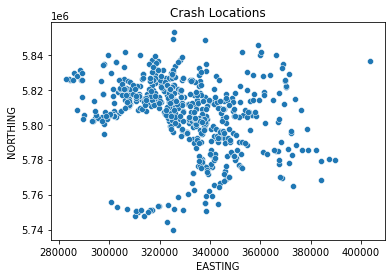

In [29]:
fig1, ax1 = plt.subplots()
ax1.set_title("Crash Locations")
crashes_east = crashes_data["EASTING"]
crashes_north = crashes_data["NORTHING"]
fig1 = sns.scatterplot(x=crashes_east, y=crashes_north)

In [30]:
# outlier point greater (easting greather than 400,000) observed
outlier = crashes_data[crashes_data["EASTING"] > 400000]
outlier

,EASTING,NORTHING,ACCIDENT_TYPE,NO_VEHICLE,TRAFFIC_VOLUME,TRAFFIC_GROWTH,HOSPITAL_CATEGORY,DIST_NEAREST_HOSPITAL
79,403569.493311,5.836405e+06,1,3,650.0,-0.005,PUBLIC,62408.764952


In [31]:
# this location is not Hume and is far away from Melbourne. This will therefore be removed
crashes_data = crashes_data.drop(79, axis="index")

Upon performing VAT analysis, the heat map generated does not produce distinct clusters due to the data being somewhat uniformly distributed. Thus the number of clusters were therefore determined using an elbow curve.

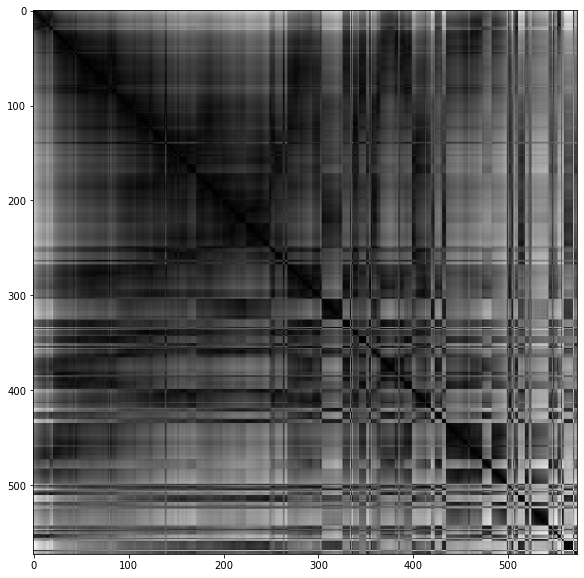

In [32]:
#first apply vat analyse to determine number of clusters
from pyclustertend import vat, ivat
crash_sites = crashes_data[["EASTING", "NORTHING"]]
vat_heatmap = scale(crash_sites)
vat(vat_heatmap)

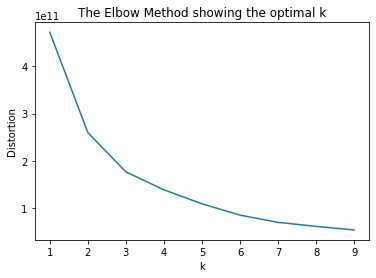

In [33]:
cluster_k = [k for k in range(1,10)]
elbow = []
for k in range(1,10):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(crashes_data[["EASTING", "NORTHING"]])
    elbow.append(kmeans.inertia_)

plt.cla
plt.figure()
plt.plot(cluster_k, elbow)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


We see that k = 3 or 4 are both acceptable values for applying kmean clustering on this data. k = 4 is chosen.

In [34]:
#find the clusters
cluster_num = 4
kmeans = cluster.KMeans(n_clusters=cluster_num)
kmeans = kmeans.fit(crashes_data[["EASTING", "NORTHING"]])
kmeans.cluster_centers_

array([[ 310875.90694522, 5820074.02564697],
       [ 334682.53739516, 5806526.9725611 ],
       [ 336399.65696492, 5767891.8921001 ],
       [ 363024.3138822 , 5806065.97942796]])

In [35]:
crashes_data["CLUSTER_LABELS"] = kmeans.labels_
crashes_data.head()

,EASTING,NORTHING,ACCIDENT_TYPE,NO_VEHICLE,TRAFFIC_VOLUME,TRAFFIC_GROWTH,HOSPITAL_CATEGORY,DIST_NEAREST_HOSPITAL,CLUSTER_LABELS
0,332356.754223,5.804290e+06,1,3,52000.0,-0.004,PUBLIC,3666.496899,1
1,323738.934777,5.826285e+06,1,5,33000.0,0.008,PUBLIC,5873.164172,0
2,318355.441610,5.823902e+06,2,2,11000.0,0.007,PUBLIC,8351.869328,0
3,329021.381635,5.825677e+06,2,1,18000.0,-0.003,PUBLIC,5280.154558,0
4,328058.324164,5.837223e+06,1,3,12000.0,0.029,PUBLIC,5915.466705,0


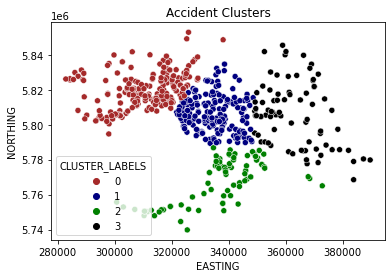

In [36]:
fig2, ax2 = plt.subplots()
ax2.set_title("Accident Clusters")
crashes_east = crashes_data["EASTING"]
crashes_north = crashes_data["NORTHING"]
crashes_cluster = crashes_data["CLUSTER_LABELS"]
colour_dict = {0: "brown", 1: "navy", 2: "green", 3: "black"}
fig2 = sns.scatterplot(x=crashes_east, y=crashes_north, hue=crashes_cluster, palette=colour_dict)


# Grid system and Results

Apply weightings to each column or than coordinates in the dataframe. 

In [37]:
#scores
crashes_data["HOSPITAL_CATEGORY"] = crashes_data["HOSPITAL_CATEGORY"].apply(lambda cell: 0.2 if cell == "PRIVATE" else 0)
crashes_data["DIST_NEAREST_HOSPITAL"] = (crashes_data["DIST_NEAREST_HOSPITAL"] - crashes_data["DIST_NEAREST_HOSPITAL"].min()) / (crashes_data["DIST_NEAREST_HOSPITAL"].max() - crashes_data["DIST_NEAREST_HOSPITAL"].min())
crashes_data["TRAFFIC_GROWTH"] =  1 - ((crashes_data["TRAFFIC_GROWTH"] - crashes_data["TRAFFIC_GROWTH"].min()) / (crashes_data["TRAFFIC_GROWTH"].max() - crashes_data["TRAFFIC_GROWTH"].min()))
crashes_data["TRAFFIC_VOLUME"] = 1 - ((crashes_data["TRAFFIC_VOLUME"] - crashes_data["TRAFFIC_VOLUME"].min()) / (crashes_data["TRAFFIC_VOLUME"].max() - crashes_data["TRAFFIC_VOLUME"].min()))
crashes_data["NO_VEHICLE"] = (crashes_data["NO_VEHICLE"] - crashes_data["NO_VEHICLE"].min()) / (crashes_data["NO_VEHICLE"].max() - crashes_data["NO_VEHICLE"].min())

#find relative frequency of each accident type
accident_dict = {}
total = crashes_data.shape[0]
for type in range(1,10):
    accident_dict[str(type)] = (crashes_data[crashes_data["ACCIDENT_TYPE"] == str(type)].shape[0]) / total

crashes_data["ACCIDENT_TYPE"] = crashes_data["ACCIDENT_TYPE"].apply(lambda cell: accident_dict[cell])

#weightings
crashes_data["WEIGHTING"] = crashes_data["ACCIDENT_TYPE"] + crashes_data["NO_VEHICLE"] + crashes_data["TRAFFIC_VOLUME"] + crashes_data["TRAFFIC_GROWTH"] + crashes_data["HOSPITAL_CATEGORY"] + crashes_data["DIST_NEAREST_HOSPITAL"]

crashes_data.head()


,EASTING,NORTHING,ACCIDENT_TYPE,NO_VEHICLE,TRAFFIC_VOLUME,TRAFFIC_GROWTH,HOSPITAL_CATEGORY,DIST_NEAREST_HOSPITAL,CLUSTER_LABELS,WEIGHTING
0,332356.754223,5.804290e+06,0.516579,0.272727,0.740074,0.730924,0.0,0.102552,1,2.362856
1,323738.934777,5.826285e+06,0.516579,0.454545,0.835084,0.682731,0.0,0.165274,0,2.654213
2,318355.441610,5.823902e+06,0.221640,0.181818,0.945095,0.686747,0.0,0.235728,0,2.271028
3,329021.381635,5.825677e+06,0.221640,0.090909,0.910091,0.726908,0.0,0.148418,0,2.097966
4,328058.324164,5.837223e+06,0.516579,0.272727,0.940094,0.598394,0.0,0.166476,0,2.494270


Grid_interval of 2000 divides each cluster roughly to 20 columns bounded by the maximum and minimum coordinates for each cluster. Compute the sums of the weighted distance and take the minimum for each cluster. 

In [38]:
grid_interval = 2000

def sum_weighted_dist(hospital_location, crashes_cluster):   
    
    #computes weighted sum for all gridpoints 
    return crashes_cluster.apply(
        lambda crash: crash["WEIGHTING"] * 
        math.dist(hospital_location, [crash["EASTING"], crash["NORTHING"]]), axis=1).sum()

def findOptimalHospitalLocation(cluster_number):
    cluster = crashes_data[crashes_data["CLUSTER_LABELS"] == cluster_number]
    
    # creates all gridpoints 
    min_northing = cluster["NORTHING"].min()
    max_northing = cluster["NORTHING"].max()
    min_easting = cluster["EASTING"].min()
    max_easting = cluster["EASTING"].max()
    easting_points = pd.DataFrame(np.arange(min_easting, max_easting, grid_interval), columns=["EASTING"])
    northing_points = pd.DataFrame(np.arange(min_northing, max_northing, grid_interval), columns=["NORTHING"])
    weighted_dist_sums = easting_points.merge(northing_points, how="cross")
    
    #finding row the smallest weighted sum and its coordinates 
    weighted_dist_sums["WEIGHTED_DIST_SUM"] = weighted_dist_sums.apply(
        lambda hospital: sum_weighted_dist([hospital["EASTING"], hospital["NORTHING"]], cluster), axis=1)
    
    weighted_dist_sums = weighted_dist_sums.sort_values(by=["WEIGHTED_DIST_SUM"], ignore_index=False)
    
    weighted_dist_sums.index = [n for n in range(weighted_dist_sums.shape[0])]
    
    return tuple(weighted_dist_sums.loc[0, ["EASTING", "NORTHING"]])

print("Cluster 0:", findOptimalHospitalLocation(0))
print("Cluster 1:", findOptimalHospitalLocation(1))
print("Cluster 2:", findOptimalHospitalLocation(2))
print("Cluster 3:", findOptimalHospitalLocation(3))

Cluster 0: (310811.45720924216, 5818692.086621046)
Cluster 1: (333753.60179524194, 5805347.778123857)
Cluster 2: (338681.4398858461, 5771785.722226524)
Cluster 3: (361134.64470054326, 5808505.971761736)


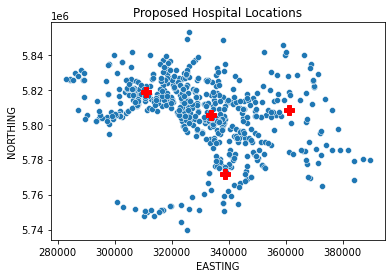

In [39]:
#plotting these results
final_locations = pd.DataFrame({"EASTING": [findOptimalHospitalLocation(n)[0] for n in range(4)], "NORTHING": [findOptimalHospitalLocation(n)[1] for n in range(4)]})

fig3, ax3 = plt.subplots()
fig3 = sns.scatterplot(x=crashes_east, y=crashes_north)
ax3.set_title("Proposed Hospital Locations")
ax3.plot(final_locations["EASTING"], final_locations["NORTHING"], 'rP', markersize=10)